# Test `seatracker` Module

This is a development notebook used as an integration test as code
is ported from Susan's original `SeaTracker.ipynb` implementation
into the `seatracker.py` module.

In [1]:
from itertools import product
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import netCDF4 as nc
import numpy as np
from scipy.integrate import ode
from scipy.interpolate import LinearNDInterpolator

import seatracker

In [2]:
%matplotlib inline

* Staggered grids : Done
* Multiple points : Done
* tmask : Done (or at least fake one done)
* off depth and onto grid (done)
* e1t etc (sketched)
* the surface (badly done)

In [3]:
def interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, point) :
    dims = len(point)
    rhs = np.zeros((3))
    if t_mask[int(point[1]), int(point[2]), int(point[3])] != 0:
        for vel, scale, coords, data in zip([0, 1, 2], [e3w, e2v, e1u,], [w_coords, v_coords, u_coords], [w, v, u]):
            indices = []
            sub_coords = []
            good = True
            for j in range(dims) :
                idx = np.digitize([point[j]], coords[j])[0]   # finds the index of region
                if (idx == len(coords[j])):
                    print (j, 'out of bounds', point[j], vel, coords[j])
                    good = False
                elif (idx == 0):
                    print (j, 'hit surface', point[j], vel, coords[j])
                    good = False
                else:
                    indices += [[idx - 1, idx]]
                    sub_coords += [coords[j][indices[-1]]]
            if good:
                indices = np.array([j for j in product(*indices)])
                sub_coords = np.array([j for j in product(*sub_coords)])
                sub_data = data[list(np.swapaxes(indices, 0, 1))]
                li = LinearNDInterpolator(sub_coords, sub_data, rescale=True) # https://www.mathworks.com/help/matlab/ref/interpn.html
                if vel == 0:
                    rhs[vel] = li([point])[0]/scale[indices[0, 0], int(point[1]), int(point[2]), int(point[3])]
                    if (rhs[vel] == 0):
                        print ('rhs', scale[indices[0, 0], int(point[1]), int(point[2]), int(point[3])])
                        print (int(point[1]), int(point[2]), int(point[3]))
                        print (t_mask[int(point[1]), int(point[2]), int(point[3])])
                else:
                    rhs[vel] = li([point])[0]/scale[indices[0, 2], indices[0, 3]]
            else:
                rhs[vel] = 0.
    return rhs
# from Jaime on Stackoverflow https://stackoverflow.com/users/110026/jaime

In [4]:
def derivatives(t, poss, t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u):
    rhs = np.zeros_like(poss)
    for ip in range(int(poss.shape[0]/3)):
        point = np.array([t, poss[0+ip*3], poss[1+ip*3], poss[2+ip*3]])
        rhs[0+ip*3:3+ip*3] = interpolator(t_mask, 
                                          e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, point)
    return np.array(rhs) # array or scalar, not a tuple

In [5]:
# Choose new random points
def random_points (t_coords, deltat, t_mask):
    t0 = t_coords[0, 0]
    yi = np.zeros((27, 3))

    good = 0
    while good == 0:
        tc = random.uniform(t0, t0+deltat)
        zc = random.uniform(0., 39.)
        yc = random.uniform(t_coords[2, 0], t_coords[2, -1])
        xc = random.uniform(t_coords[3, 0], t_coords[3, -1])

        count = 0
        for k in range(3):
            for j in range(3):
                for i in range(3):
                    yi[count, 0] = min(zc + k, 39.)
                    yi[count, 1] = min(yc + j, t_coords[2, -1])
                    yi[count, 2] = min(xc + i, t_coords[3, -1])
#                     print (yi[count], math.floor(yi[count, 0]))
                    good += t_mask[math.floor(yi[count, 0]), math.floor(yi[count, 1]), math.floor(yi[count, 2])]
                    count += 1

#         print (tc, zc, yc, xc, good)

    return tc, yi

In [6]:
# Choose grid around a specific point
def grid_points (t_coords, deltat, t_mask, tc, zc, yc, xc):
    t0 = t_coords[0, 0]
    yi = np.zeros((27, 3))

    good = 0
    count = 0
    for k in range(3):
        for j in range(3):
            for i in range(3):
                yi[count, 0] = min(zc + k, 39.)
                yi[count, 1] = min(yc + j, t_coords[2, -1])
                yi[count, 2] = min(xc + i, t_coords[3, -1])
                good += t_mask[math.floor(yi[count, 0]), math.floor(yi[count, 1]), math.floor(yi[count, 2])]
                if t_mask[math.floor(yi[count, 0]), math.floor(yi[count, 1]), math.floor(yi[count, 2])] == 0:
                    print(zc+k, yc+j, xc+i)
                count += 1

#     print (tc, zc, yc, xc, good)

    return tc, yi

In [7]:
# Set up run: test points are not on the walls
def test_points(t_coords, u_coords, v_coords, w_coords, tmask, yi):
    testpoint = np.zeros((4))
    for point in range(yi.shape[0]):
        testpoint[1:] = yi[point]
        testpoint[0] = t_coords[0, 0]
        velocity = interpolator(t_mask, e3w, e2v, e1u, w_coords, v_coords, u_coords, w, v, u, testpoint)
        if np.all(velocity == [0, 0, 0]):
            t_mask[int(testpoint[1]), int(testpoint[2]), int(testpoint[3])] = 0
            print (int(testpoint[1]), int(testpoint[2]), int(testpoint[3]), 'zerod')
    return t_mask

In [8]:
def get_initial_data(fractiondepth, totaldepth, e3w0):
#     udataset = nc.Dataset('../myResults/SalishSea_1h_20160801_20160801_grid_U.nc')
    udataset = nc.Dataset('hindcast/SalishSea_1h_20160801_20160801_grid_U.nc')
    tcorrs = udataset['time_counter'][:3]
    deltat = tcorrs[1] - tcorrs[0]
#    xcorrs = udataset['gridX'][:]
#    ycorrs = udataset['gridY'][:]
    xcorrs = range(udataset.dimensions['x'].size)
    ycorrs = range(udataset.dimensions['y'].size)
    depthsize = udataset['depthu'][:].shape[0]
    zcorrs = np.linspace(0, depthsize, depthsize+1) - 0.5  # this makes it depth, not grid point 
    # and I need one above the surface

    longaxis = max(len(xcorrs), len(ycorrs), len(zcorrs), len(tcorrs))
    t_coords = np.zeros((4, longaxis))
    t_coords[0, 0:len(tcorrs)] = tcorrs
    t_coords[0, len(tcorrs):] = max(tcorrs)
    t_coords[1, 0:len(zcorrs)] = zcorrs
    t_coords[1, len(zcorrs):] = max(zcorrs)
    t_coords[2, 0:len(ycorrs)] = ycorrs
    t_coords[2, len(ycorrs):] = max(ycorrs)
    t_coords[3, 0:len(xcorrs)] = xcorrs
    t_coords[3, len(xcorrs):] = max(xcorrs)
    # other grids
    u_coords = np.copy(t_coords)
    u_coords[3] = t_coords[3] + 0.5
    v_coords = np.copy(t_coords)
    v_coords[2] = t_coords[2] + 0.5
    w_coords = np.copy(t_coords)
    w_coords[1] = t_coords[1] + 0.5

    u = np.zeros((3, len(zcorrs), len(ycorrs), len(xcorrs)))
    u[:, 1:] = udataset['vozocrtx'][0:3]
    u[:, 0] = 2 * u[:, 1] - u[:, 2]

    v = np.zeros_like(u)
#     vdataset = nc.Dataset('../myResults/SalishSea_1h_20160801_20160801_grid_V.nc')
    vdataset = nc.Dataset('hindcast/SalishSea_1h_20160801_20160801_grid_V.nc')
    v[:, 1:] = vdataset['vomecrty'][0:3]
    v[:, 0] = 2 * v[:, 1] - v[:, 2]

#     wdataset = nc.Dataset('../myResults/SalishSea_1h_20160801_20160801_grid_W.nc')
    wdataset = nc.Dataset('hindcast/SalishSea_1h_20160801_20160801_grid_W.nc')
    w = np.zeros_like(u)
    w = - wdataset['vovecrtz'][0:3] # change to velocity down (increasing depth)

#     tdataset = nc.Dataset('../myResults/SalishSea_1h_20160801_20160801_grid_T.nc')
    tdataset = nc.Dataset('hindcast/SalishSea_1h_20160801_20160801_grid_T.nc')
    ssh = tdataset['sossheig'][0:3]
    e3w = np.empty_like(w)
    for i in range(3):
        e3w[i] = e3w0*(1 + ssh[i]/totaldepth)
    
    nextindex = 3

    return u, v, w, tcorrs, t_coords, u_coords, v_coords, w_coords, deltat, nextindex, e3w, udataset, vdataset, wdataset, tdataset

In [9]:
def update_arrays(totaldepth, fractiondepth, e3w0, e3w, tcorrs, u_coords, v_coords, w_coords, u, v, w, deltat, nextindex, udataset, vdataset, wdataset, tdataset):
    tcorrs  = tcorrs + deltat
    u_coords[0, 0:len(tcorrs)] = tcorrs
    u_coords[0, len(tcorrs):] = max(tcorrs)
    v_coords[0] = u_coords[0]
    w_coords[0] = u_coords[0]
    u[0:2] = u[1:3]
    u[2, 1:] = udataset['vozocrtx'][nextindex]
    u[2, 0] = 2 * u[2, 1] - u[2, 2]
    v[0:2] = v[1:3]
    v[2, 1:] = vdataset['vomecrty'][nextindex]
    v[2, 0] = 2 * v[2, 1] - v[2, 2]
    w[0:2] = w[1:3]
    wtemp = np.zeros([1, w.shape[1], w.shape[2], w.shape[3]])
    wtemp[0] = - wdataset['vovecrtz'][nextindex]

    ssh = tdataset['sossheig'][nextindex]
    e3w[0:2] = e3w[1:3]
    e3w[2] = e3w0*(1 + ssh/totaldepth)
    
    nextindex += 1
    return tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex, e3w

In [10]:
def myplotter(ax, t0, y0, npoints, cmap, yc, initial=False):
    ct = 20.
    if initial:
        for ip in range(npoints):
            ax[1, 0].plot(t0, -y0[ip, 0], 'ko')
            ax[0, 0].plot(t0, y0[ip, 1], 'ks')
            ax[0, 1].plot(t0, y0[ip, 2], 'k^')
            ax[2, 0].plot(y0[ip, 2], y0[ip, 1], 'bx')
            ax[2, 1].plot(y0[ip, 2], y0[ip, 1], 'bx')
            ax[1, 1].scatter(y0[ip, 2], y0[ip, 1], -y0[ip, 0], c='k')
    else:
        for ip in range(npoints):
            ax[1, 0].plot(t0, -y0[ip, 0], 'bo')
            ax[0, 0].scatter(t0, y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[0, 1].scatter(t0, y0[ip, 2], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[2, 0].scatter(y0[ip, 2], y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[2, 1].scatter(y0[ip, 2], y0[ip, 1], color=cmap((y0[ip, 0]-yc+ct)/(2*ct)))
            ax[1, 1].scatter(y0[ip, 2], y0[ip, 1], -y0[ip, 0], c='b')

In [11]:
def foo():
    # set up graphing
    cmap = mpl.cm.get_cmap('plasma_r')
    fig, ax = plt.subplots(3, 2)
    fig.clf()
    fig = plt.figure(figsize=(15, 20))
    ax[0, 0] = fig.add_subplot(3, 2, 1)
    ax[0, 1] = fig.add_subplot(3, 2, 2)
    ax[1, 0] = fig.add_subplot(3, 2, 3)
    ax[1, 1] = fig.add_subplot(3, 2, 4, projection='3d')
    ax[2, 0] = fig.add_subplot(3, 2, 5)
    ax[2, 1] = fig.add_subplot(3, 2, 6)

    # get initial data
    # t_mask, e1u, e2v, e3w0, totaldepth, fractiondepth = initialize_mesh('../myResults/mesh_mask201702.nc')
    t_mask, e1u, e2v, e3w0, totaldepth, fractiondepth = seatracker.initialize_mesh('../../MEOPAR/grid/mesh_mask201702.nc')
    (u, v, w, tcorrs, t_coords, u_coords, v_coords, 
     w_coords, deltat, nextindex, e3w, udataset, vdataset, wdataset, tdataset) = get_initial_data(fractiondepth, totaldepth, e3w0)
    # get a new point
    tc, yi = random_points (t_coords, deltat, t_mask)
    # tc, yi = grid_points(t_coords, deltat, t_mask, tc, 25-1, 446-1, 304-1)

    ax[2, 0].pcolormesh(np.arange(398) - 0.5, np.arange(898) - 0.5, t_mask[0], cmap='Greys_r')
    ax[2, 0].set_xlim(t_coords[3, 0], t_coords[3, -1])
    ax[2, 0].set_ylim(t_coords[2, 0], t_coords[2, -1])

    ax[2, 1].pcolormesh(np.arange(398) - 0.5, np.arange(898) - 0.5, t_mask[0], cmap='Greys_r')
    size = 40

    ax[2, 1].set_xlim(yi[0, 2]-size, yi[0, 2]+size)
    ax[2, 1].set_ylim(yi[0, 1]-size, yi[0, 1]+size)

    ax[0, 0].set_xlim(tcorrs[0], tcorrs[0]+24.5*deltat)
    ax[0, 1].set_xlim(tcorrs[0], tcorrs[0]+24.5*deltat)


    # set up values for integrator
    t0 = tcorrs[0]
    dt = deltat/10.
    npoints = yi.shape[0]
    y0 = np.copy(yi)
    yp = np.ndarray.flatten(y0)

    # plot initial points
    myplotter(ax, t0, y0, npoints, cmap, y0[0, 0], initial=True)

    # initialize integrator    
    myintegrator = ode(derivatives).set_integrator('dopri5', atol=0.01) # https://www.mathworks.com/help/matlab/ref/ode45.html
    myintegrator.set_initial_value(yp, t0).set_f_params(t_mask, e3w, e2v, e1u, 
                                                        w_coords, v_coords, u_coords, w, v, u)

    # first segment
    t1 = t0 + 1.5*deltat

    while myintegrator.successful() and myintegrator.t < t1:
        myintegrator.integrate(myintegrator.t + dt)
        myplotter(ax, myintegrator.t, np.reshape(myintegrator.y, (npoints, 3)), npoints, cmap, y0[0, 0])

    # and the rest
    for count in range(0):
        # update arrays
        tcorrs, u_coords, v_coords, w_coords, u, v, w, nextindex, e3w = (
            update_arrays(totaldepth, fractiondepth, e3w0, e3w, tcorrs, u_coords, v_coords, w_coords, u, v, w, 
                          deltat, nextindex, udataset, vdataset, wdataset, tdataset))
        print(nextindex)
        t1 += deltat

        while myintegrator.successful() and myintegrator.t < t1:
            myintegrator.integrate(myintegrator.t + dt)
            myplotter(ax, myintegrator.t, np.reshape(myintegrator.y, (npoints, 3)), npoints, cmap, y0[0, 0])

/home/doug/Documents/MOAD/seatracker-python/seatracker.py:41: RuntimeWarning: divide by zero encountered in true_divide
  fractiondepth = gdepw_0 / totaldepth
/home/doug/Documents/MOAD/seatracker-python/seatracker.py:41: RuntimeWarning: invalid value encountered in true_divide
  fractiondepth = gdepw_0 / totaldepth


rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 351 63
1
rhs 16.0731
30 3

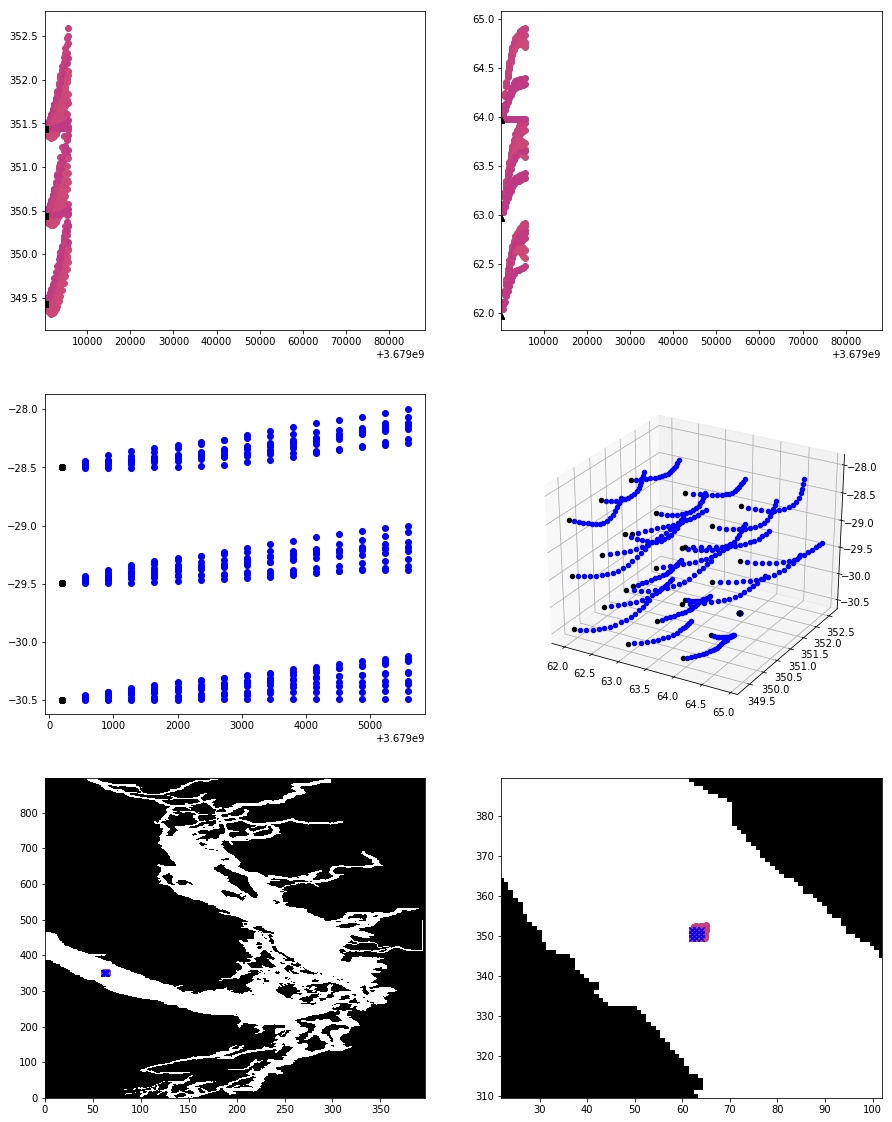

In [12]:
%%timeit -n1 -r1

from importlib import reload
reload(seatracker)

foo()

In [ ]:
plt.plot(myintegrator.y[0:3], 'o-')
print(myintegrator.y[0:3])

In [ ]:
grid_points(t_coords, deltat, t_mask, tc, 25, 446, 304)

In [ ]:
(u, v, w, tcorrs, t_coords, u_coords, v_coords, 
 w_coords, deltat, nextindex, e3w, udataset, vdataset, wdataset, tdataset) = get_initial_data(fractiondepth, totaldepth, e3w0)
print (w_coords.shape)
print (u.shape)
print ('---u---')
print (u[0, 23:26, 444:447, 302:306])
print ('---v---')
print (v[0, 23:26, 444:447, 302:306])
print ('---w---')
print (w[0, 23:26, 444:447, 302:306])
print (u[0, 23, 444, 302])

In [ ]:
plt.pcolormesh(t_mask[0, t_coords[2, 0]:t_coords[2, -1]+1, t_coords[3, 0]:t_coords[3, -1]+1])
plt.colorbar()

In [ ]:
plt.scatter(y0[:, 1], y0[:, 2], color=cmap(y0[:,0]/5.0))

In [ ]:
np.mean([-0.11902476, -0.08500474, -0.1502234,  -0.14704061])

In [ ]:
yi